## Multi-Variate XGBoost regressor for 1-h wind-speed forecast

In [1]:
import numpy as np
import pandas as pd


In [2]:
def make_lags(df, cols, lags):
    return pd.concat([df[col].shift(lag).rename(f"{col}_L{lag}") for col in cols for lag in lags], axis=1)

In [3]:
df = pd.read_csv("../../../data/cleaned/multi_var_wind_hourly_cleaned.csv")
df = df.sort_values('datetime').reset_index(drop=True)
df['wind_speed'] = df['wind_speed'].astype(float)

In [4]:
df.head()

,datetime,pressure,temperature,humidity,wind_direction,wind_speed,u,v,wind_speed_reconstructed,pressure_24h
0,2024-01-01 00:00:00,758.466667,-1.016667,62.166667,137.000000,0.100000,-0.022693,-0.047340,0.052498,758.466667
1,2024-01-01 01:00:00,758.383333,-1.533333,64.000000,207.166667,0.283333,-0.113825,0.011167,0.114371,758.425000
2,2024-01-01 02:00:00,758.383333,-1.150000,61.333333,63.000000,0.200000,-0.169286,-0.061781,0.180207,758.411111
3,2024-01-01 03:00:00,758.783333,-1.166667,58.666667,181.166667,0.500000,0.142045,-0.397690,0.422296,758.504167
4,2024-01-01 04:00:00,759.000000,-1.483333,62.166667,109.666667,0.966667,-0.512590,-0.609574,0.796448,758.603333


In [5]:
df.columns

Index(['datetime', 'pressure', 'temperature', 'humidity', 'wind_direction',
       'wind_speed', 'u', 'v', 'wind_speed_reconstructed', 'pressure_24h'],
      dtype='object')

In [6]:
df = df[['datetime', 'pressure', 'temperature', 'humidity', 'wind_speed', 'u', 'v']]

In [7]:
df.head()

,datetime,pressure,temperature,humidity,wind_speed,u,v
0,2024-01-01 00:00:00,758.466667,-1.016667,62.166667,0.100000,-0.022693,-0.047340
1,2024-01-01 01:00:00,758.383333,-1.533333,64.000000,0.283333,-0.113825,0.011167
2,2024-01-01 02:00:00,758.383333,-1.150000,61.333333,0.200000,-0.169286,-0.061781
3,2024-01-01 03:00:00,758.783333,-1.166667,58.666667,0.500000,0.142045,-0.397690
4,2024-01-01 04:00:00,759.000000,-1.483333,62.166667,0.966667,-0.512590,-0.609574


In [8]:
# ensure the column is datetime *type*
df['date'] = pd.to_datetime(df['datetime'])   # or df['datetime'] if that's the name

# now extract hour
df['hour'] = df['date'].dt.hour
df['sin_h'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_h'] = np.cos(2 * np.pi * df['hour'] / 24)

In [9]:
df.head()

,datetime,pressure,temperature,humidity,wind_speed,u,v,date,hour,sin_h,cos_h
0,2024-01-01 00:00:00,758.466667,-1.016667,62.166667,0.100000,-0.022693,-0.047340,2024-01-01 00:00:00,0,0.000000,1.000000
1,2024-01-01 01:00:00,758.383333,-1.533333,64.000000,0.283333,-0.113825,0.011167,2024-01-01 01:00:00,1,0.258819,0.965926
2,2024-01-01 02:00:00,758.383333,-1.150000,61.333333,0.200000,-0.169286,-0.061781,2024-01-01 02:00:00,2,0.500000,0.866025
3,2024-01-01 03:00:00,758.783333,-1.166667,58.666667,0.500000,0.142045,-0.397690,2024-01-01 03:00:00,3,0.707107,0.707107
4,2024-01-01 04:00:00,759.000000,-1.483333,62.166667,0.966667,-0.512590,-0.609574,2024-01-01 04:00:00,4,0.866025,0.500000


In [10]:
LAGS = [1,2,3,23,24,25,48]

In [11]:
# 1. Define features to lag (Inertia & Rate of Change)
cols_to_lag = ['pressure', 'temperature', 'wind_speed', 'u', 'v']


# 2. Apply the lag function
df_lags = make_lags(df, cols_to_lag, LAGS)

# 3. Join lags back to the main dataframe
df_final = pd.concat([df, df_lags], axis=1)

# 4. Create the Target (Next Hour Wind Speed)
# Shift -1 moves the next hour's value to the current row
df_final['target_wind_speed'] = df_final['wind_speed'].shift(-1)

# 5. Clean up
# Drop rows with NaN (created by lags at the start and target shift at the end)
df_final.dropna(inplace=True)

# 6. Final Feature Selection
# Drop original columns that are now represented by lags or aren't needed at time t for prediction
# Keep 'hour_sin', 'hour_cos', 'month_sin', 'month_cos' and all '_L' columns.
# You usually keep current state (t) cols like 'pressure', 'u', 'v' as well.
X = df_final.drop(['datetime', 'target_wind_speed'], axis=1)
y = df_final['target_wind_speed']

print("Features:", X.columns.tolist())
print(X.head())

Features: ['pressure', 'temperature', 'humidity', 'wind_speed', 'u', 'v', 'date', 'hour', 'sin_h', 'cos_h', 'pressure_L1', 'pressure_L2', 'pressure_L3', 'pressure_L23', 'pressure_L24', 'pressure_L25', 'pressure_L48', 'temperature_L1', 'temperature_L2', 'temperature_L3', 'temperature_L23', 'temperature_L24', 'temperature_L25', 'temperature_L48', 'wind_speed_L1', 'wind_speed_L2', 'wind_speed_L3', 'wind_speed_L23', 'wind_speed_L24', 'wind_speed_L25', 'wind_speed_L48', 'u_L1', 'u_L2', 'u_L3', 'u_L23', 'u_L24', 'u_L25', 'u_L48', 'v_L1', 'v_L2', 'v_L3', 'v_L23', 'v_L24', 'v_L25', 'v_L48']
      pressure  temperature   humidity  wind_speed         u         v  \
48  755.666667    -2.616667  91.333333    0.100000  0.064191 -0.076499   
49  755.133333    -1.583333  77.000000    0.616667  0.499208 -0.335945   
50  754.633333    -1.283333  70.333333    0.500000  0.195515 -0.177460   
51  754.516667    -1.833333  76.166667    0.033333 -0.029432  0.015649   
52  754.950000    -0.983333  74.833333  

In [12]:
df_final.head()

,datetime,pressure,temperature,humidity,wind_speed,u,v,date,hour,sin_h,...,u_L25,u_L48,v_L1,v_L2,v_L3,v_L23,v_L24,v_L25,v_L48,target_wind_speed
48,2024-01-03 00:00:00,755.666667,-2.616667,91.333333,0.100000,0.064191,-0.076499,2024-01-03 00:00:00,0,0.000000,...,-0.459502,-0.022693,-0.681359,-0.914684,-0.173174,-0.096850,-0.322368,-0.419428,-0.047340,0.616667
49,2024-01-03 01:00:00,755.133333,-1.583333,77.000000,0.616667,0.499208,-0.335945,2024-01-03 01:00:00,1,0.258819,...,-0.871871,-0.113825,-0.076499,-0.681359,-0.914684,-0.323016,-0.096850,-0.322368,0.011167,0.500000
50,2024-01-03 02:00:00,754.633333,-1.283333,70.333333,0.500000,0.195515,-0.177460,2024-01-03 02:00:00,2,0.500000,...,-0.889509,-0.169286,-0.335945,-0.076499,-0.681359,-1.400511,-0.323016,-0.096850,-0.061781,0.033333
51,2024-01-03 03:00:00,754.516667,-1.833333,76.166667,0.033333,-0.029432,0.015649,2024-01-03 03:00:00,3,0.707107,...,-0.572663,0.142045,-0.177460,-0.335945,-0.076499,-1.688442,-1.400511,-0.323016,-0.397690,0.116667
52,2024-01-03 04:00:00,754.950000,-0.983333,74.833333,0.116667,-0.113563,0.023849,2024-01-03 04:00:00,4,0.866025,...,0.187362,-0.512590,0.015649,-0.177460,-0.335945,-0.070495,-1.688442,-1.400511,-0.609574,0.566667


In [13]:
df_final.columns

Index(['datetime', 'pressure', 'temperature', 'humidity', 'wind_speed', 'u',
       'v', 'date', 'hour', 'sin_h', 'cos_h', 'pressure_L1', 'pressure_L2',
       'pressure_L3', 'pressure_L23', 'pressure_L24', 'pressure_L25',
       'pressure_L48', 'temperature_L1', 'temperature_L2', 'temperature_L3',
       'temperature_L23', 'temperature_L24', 'temperature_L25',
       'temperature_L48', 'wind_speed_L1', 'wind_speed_L2', 'wind_speed_L3',
       'wind_speed_L23', 'wind_speed_L24', 'wind_speed_L25', 'wind_speed_L48',
       'u_L1', 'u_L2', 'u_L3', 'u_L23', 'u_L24', 'u_L25', 'u_L48', 'v_L1',
       'v_L2', 'v_L3', 'v_L23', 'v_L24', 'v_L25', 'v_L48',
       'target_wind_speed'],
      dtype='object')

In [27]:
# 3. train/test split (last 720 rows locked)
train_end = len(df_final) - 720
test_df = df_final.iloc[train_end:].copy()

current_obs = ['pressure', 'temperature', 'u', 'v', 'wind_speed']
FEATS = [c for c in df_final.columns if '_L' in c] + ['sin_h', 'cos_h'] + current_obs



In [28]:
FEATS

['pressure_L1',
 'pressure_L2',
 'pressure_L3',
 'pressure_L23',
 'pressure_L24',
 'pressure_L25',
 'pressure_L48',
 'temperature_L1',
 'temperature_L2',
 'temperature_L3',
 'temperature_L23',
 'temperature_L24',
 'temperature_L25',
 'temperature_L48',
 'wind_speed_L1',
 'wind_speed_L2',
 'wind_speed_L3',
 'wind_speed_L23',
 'wind_speed_L24',
 'wind_speed_L25',
 'wind_speed_L48',
 'u_L1',
 'u_L2',
 'u_L3',
 'u_L23',
 'u_L24',
 'u_L25',
 'u_L48',
 'v_L1',
 'v_L2',
 'v_L3',
 'v_L23',
 'v_L24',
 'v_L25',
 'v_L48',
 'sin_h',
 'cos_h',
 'pressure',
 'temperature',
 'u',
 'v',
 'wind_speed']

In [29]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats # Used for parameter distributions

# --- Assumed Setup (from your original code) ---
# df = ... (your DataFrame)
# FEATS = [...] (your list of feature names)
# train_end = ... (the index where initial training ends)
# test_df = df.iloc[train_end:].copy()
# m = ... (your metrics module, e.g., sklearn.metrics)
# -------------------------------------------------

### 1. Define Parameter Distribution for RandomizedSearch
# We use distributions (like uniform, loguniform) instead of a fixed grid
# This is much faster and more efficient for periodic tuning.
param_dist = {
    'n_estimators': stats.randint(100, 1000),
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.loguniform(0.01, 0.3),
    'subsample': stats.uniform(0.6, 0.4), # [0.6, 1.0]
    'colsample_bytree': stats.uniform(0.6, 0.4), # [0.6, 1.0]
    'gamma': stats.uniform(0, 0.5),
    'reg_alpha': stats.loguniform(1e-3, 1.0),
    'reg_lambda': stats.loguniform(1e-3, 1.0),
}

### 2. Define Tuning and Retraining Settings
RETRAIN_INTERVAL = 168 # hours (weekly)
TUNING_WINDOW_HOURS = 2160 # Approx 3 months for tuning
N_ITER_RANDOM_SEARCH = 15 # Number of param combinations to try (faster)
N_SPLITS_INNER_CV = 3 # Fewer splits for speed during tuning


In [30]:

### 3. Rolling Retraining and Re-Tuning Loop
print("Starting rolling forecast with periodic re-tuning...")

preds = []
model = None # Start with no model
current_best_params = {} # Will be set on the first run

for t in range(train_end, len(df_final)):

    # Check if it's time to retrain and re-tune
    if (t - train_end) % RETRAIN_INTERVAL == 0:
        print(f"\n--- Retraining and Re-Tuning at index {t} ---")
        
        # --- A. RE-TUNING on a SLIDING window ---
        # We tune on a *recent* window to adapt to new conditions
        tune_start_idx = max(0, t - TUNING_WINDOW_HOURS)
        tune_window_df = df_final.iloc[tune_start_idx:t]
        
        X_tune = tune_window_df[FEATS].values
        y_tune = tune_window_df['target_wind_speed'].values
        
        print(f"Running RandomizedSearch on window {tune_start_idx} to {t}...")
        
        # Use TimeSeriesSplit for the inner cross-validation
        tscv_inner = TimeSeriesSplit(n_splits=N_SPLITS_INNER_CV)
        
        rs = RandomizedSearchCV(
            estimator=xgb.XGBRegressor(objective='reg:absoluteerror', 
                                       random_state=42, n_jobs=-1),
            param_distributions=param_dist,
            n_iter=N_ITER_RANDOM_SEARCH, # Much faster than grid search
            cv=tscv_inner,
            scoring='neg_mean_absolute_error',
            verbose=0, # Set to 1 or more for details
            n_jobs=-1
        )
        
        rs.fit(X_tune, y_tune)
        
        # Update the parameters to use for this week's model
        current_best_params = rs.best_params_
        print(f"New best parameters found: {current_best_params}")

        # --- B. RE-TRAINING on an EXPANDING window ---
        # We train the final model on all available history
        # using the *newly found* best parameters.
        train_window_df = df_final.iloc[:t] 
        X_train_window = train_window_df[FEATS].values
        y_train_window = train_window_df['target_wind_speed'].values
        
        print(f"Retraining model on window 0 to {t}...")
        model = xgb.XGBRegressor(objective='reg:absoluteerror', 
                                 random_state=42, n_jobs=-1, 
                                 **current_best_params) # Use the new params
        
        model.fit(X_train_window, y_train_window)
        print("Model retrained successfully.")

    # --- C. PREDICTION ---
    # This happens every hour, using the most recently trained model
    
    # Handle the very first prediction if model isn't trained yet
    if model is None:
        # This case should be handled, e.g., by training a default
        # model before the loop. For this structure, we'll
        # just predict 0 or NaN for simplicity until first retrain.
        print("Waiting for first retraining cycle...")
        preds.append(np.nan) # Or a default value
        continue

    x_next = df_final.iloc[t][FEATS].values.reshape(1,-1)
    preds.append(model.predict(x_next)[0])


Starting rolling forecast with periodic re-tuning...

--- Retraining and Re-Tuning at index 9560 ---
Running RandomizedSearch on window 7400 to 9560...
New best parameters found: {'colsample_bytree': np.float64(0.7590336371046834), 'gamma': np.float64(0.16239581671998754), 'learning_rate': np.float64(0.014009156947769757), 'max_depth': 3, 'n_estimators': 491, 'reg_alpha': np.float64(0.00873001422204146), 'reg_lambda': np.float64(0.017879127552745438), 'subsample': np.float64(0.6800995631637649)}
Retraining model on window 0 to 9560...
Model retrained successfully.

--- Retraining and Re-Tuning at index 9728 ---
Running RandomizedSearch on window 7568 to 9728...
New best parameters found: {'colsample_bytree': np.float64(0.7238036421890545), 'gamma': np.float64(0.16040177199719918), 'learning_rate': np.float64(0.03430709427756866), 'max_depth': 5, 'n_estimators': 537, 'reg_alpha': np.float64(0.40426101599169306), 'reg_lambda': np.float64(0.00407162973255756), 'subsample': np.float64(0.65

In [31]:
X_train_window.shape

(10232, 42)

In [23]:
import sklearn.metrics as m

In [37]:

# --- 4. Evaluation ---
test_df['pred_xgb_dynamic'] = preds
# Drop any initial NaNs if we had them
test_df = test_df.dropna(subset=['pred_xgb_dynamic'])

print("\n--- Final Results ---")
print("XGB MAE with Dynamic Re-Tuning:", 
      m.mean_absolute_error(test_df['target_wind_speed'], test_df['pred_xgb_dynamic']))


--- Final Results ---
XGB MAE with Dynamic Re-Tuning: 0.6550399452254728


In [38]:
# Get feature importance
importance = pd.DataFrame({
    'feature': FEATS,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance.head(5))

          feature  importance
41     wind_speed    0.204989
39              u    0.140585
40              v    0.059927
14  wind_speed_L1    0.047057
35          sin_h    0.042378


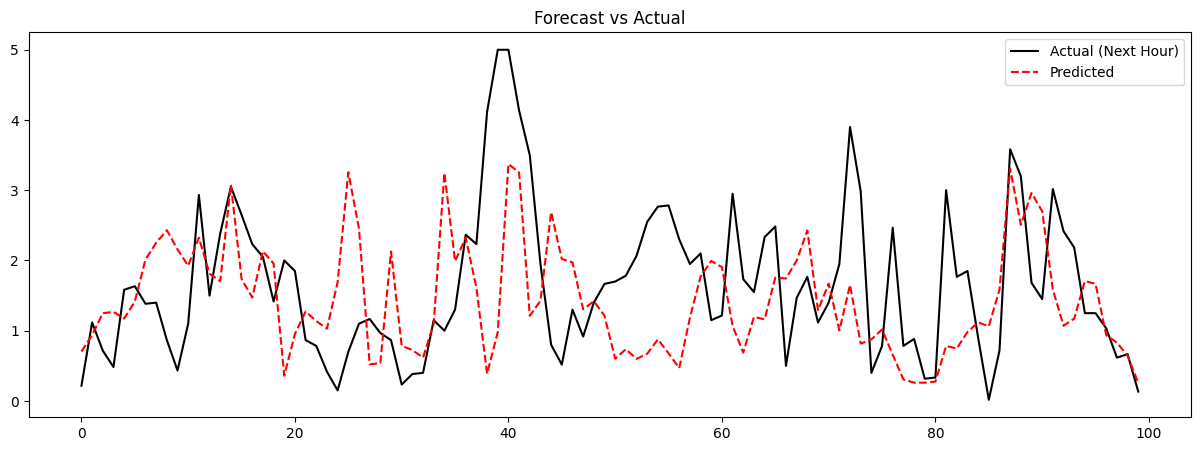

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_tune[-100:], label='Actual (Next Hour)', color='black')
plt.plot(preds[-100:], label='Predicted', color='red', linestyle='--')
plt.legend()
plt.title("Forecast vs Actual")
plt.show()

In [36]:
test_df.columns

Index(['datetime', 'pressure', 'temperature', 'humidity', 'wind_speed', 'u',
       'v', 'date', 'hour', 'sin_h', 'cos_h', 'pressure_L1', 'pressure_L2',
       'pressure_L3', 'pressure_L23', 'pressure_L24', 'pressure_L25',
       'pressure_L48', 'temperature_L1', 'temperature_L2', 'temperature_L3',
       'temperature_L23', 'temperature_L24', 'temperature_L25',
       'temperature_L48', 'wind_speed_L1', 'wind_speed_L2', 'wind_speed_L3',
       'wind_speed_L23', 'wind_speed_L24', 'wind_speed_L25', 'wind_speed_L48',
       'u_L1', 'u_L2', 'u_L3', 'u_L23', 'u_L24', 'u_L25', 'u_L48', 'v_L1',
       'v_L2', 'v_L3', 'v_L23', 'v_L24', 'v_L25', 'v_L48', 'target_wind_speed',
       'pred_xgb_dynamic'],
      dtype='object')

In [35]:
from sklearn.metrics import mean_absolute_error
# Ensure y_test and preds are unscaled
real_mae = mean_absolute_error(y_test, preds)
print(f"Real MAE: {real_mae}")

NameError: name 'y_test' is not defined